In [10]:
%matplotlib notebook
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scipy.io as sio
import pandas as pd
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from scipy.ndimage.interpolation import shift
from functools import reduce
import time

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG
from utils.general import *
from utils.file_io import *


In [15]:
def graph_weight_matrix(mat, title, v_max=None, ax=None, cmap='hot'):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
    else:
        ax.clear()
    ax.matshow(mat, vmin=0, vmax=v_max if v_max is not None else mat.max(), cmap=cmap) # 'gist_stern'
    ax.set_title(title)
#     ax.set_xlim(0, 100)
#     ax.set_ylim(100, 0)
    set_font_size(ax, 14)

In [16]:
def load_exp_data(direc, cut=None, layer_size=20, row_min=0, row_max=None, col_min=0, col_max=None):
    file_names = [f for f in sorted(all_files_from_dir(direc))]
    if cut is not None:
        file_names = file_names[:cut]
        
    df = pd.DataFrame({})
    
    for i_f in range(0, len(file_names)):
        file = file_names[i_f]
        loaded = sio.loadmat(os.path.join(direc, file))
        
        first_spk_times = loaded['first_spk_times'][0]
        w_r_e = loaded['w_r_e']
        
        if row_max is None:
            row_max = w_r_e.shape[0]
        if col_max is None:
            col_max = w_r_e.shape[1]
        target_w_r_e = w_r_e[row_min:row_max, col_min:col_max]
        
        summed_incoming_weights = target_w_r_e.sum(axis=1)
        
        last_layer_active = 0
        layer_weights = []
        
        for i in range(0, len(first_spk_times), layer_size):
            layer_active = np.any(~np.isnan(first_spk_times[i:i+layer_size]))
            if layer_active:
                last_layer_active = i/layer_size
        
            layer_weight = np.sum(summed_incoming_weights[i:(i + layer_size)])
            layer_weights.append(layer_weight)
        
        df = df.append({
            'index': i_f,
            'last_layer_active': last_layer_active,
            'first_spk_times': first_spk_times,
            'layer_weights': layer_weights,
            'mean_incoming_summed_weights': np.mean(summed_incoming_weights),
            'std_incoming_summed_weights': np.std(summed_incoming_weights),
        }, ignore_index=True)
    
    return df

In [19]:
all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), ['noise_ff_1.0_pf_0.3_pr_0.0_eir_1.8_ier_0.3'])

<IPython.core.display.Javascript object>


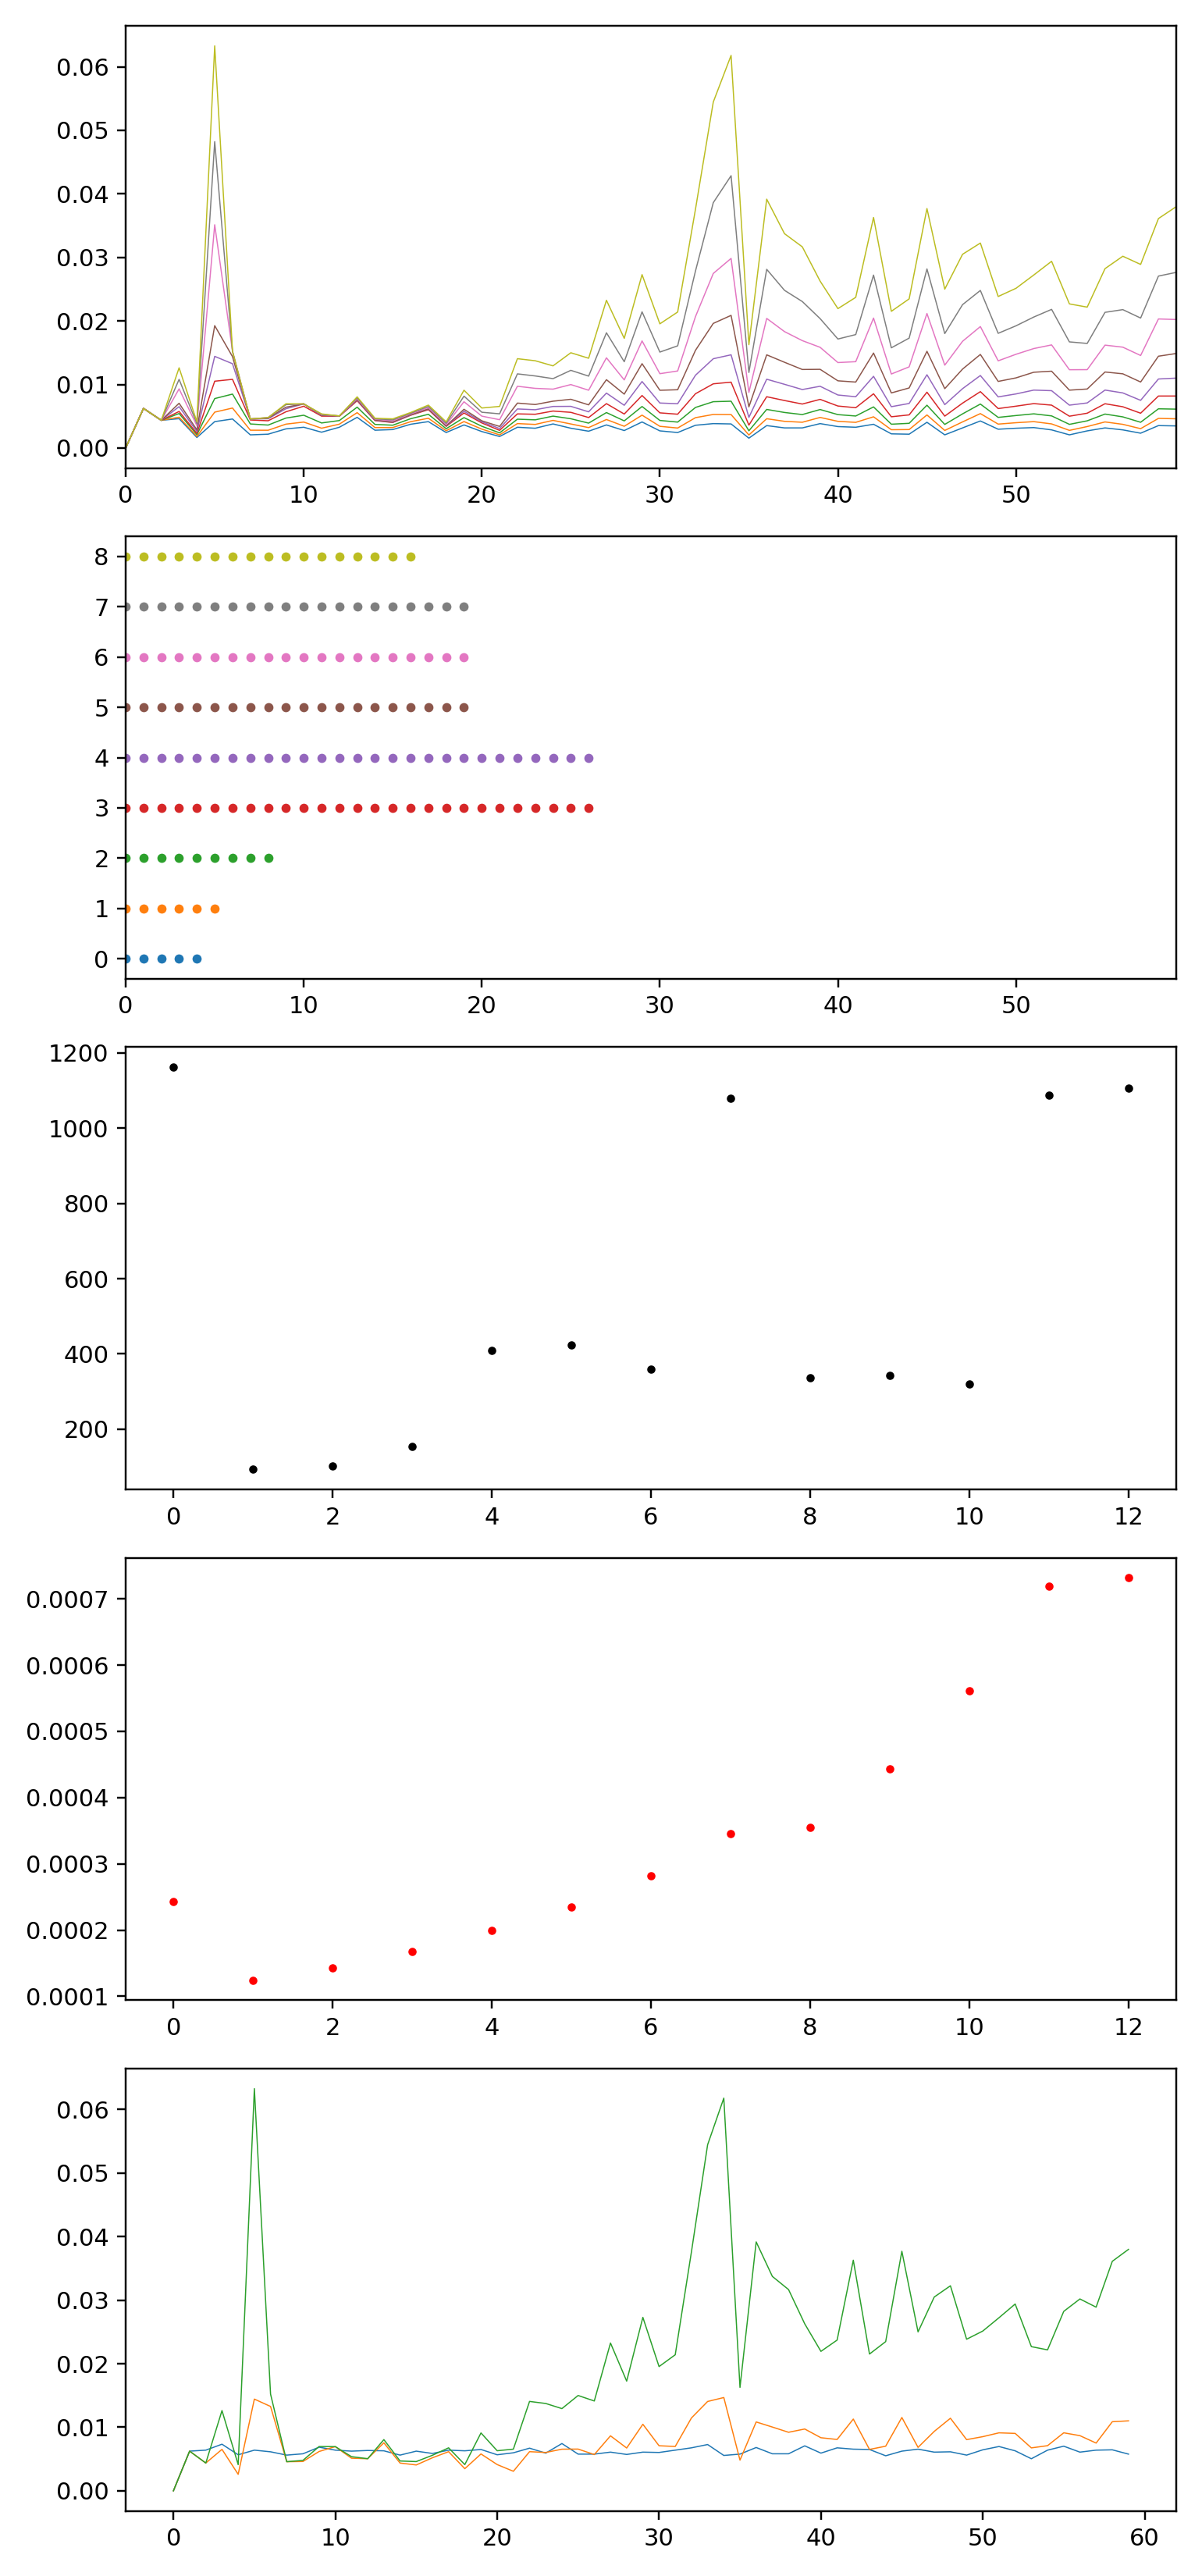

<IPython.core.display.Javascript object>


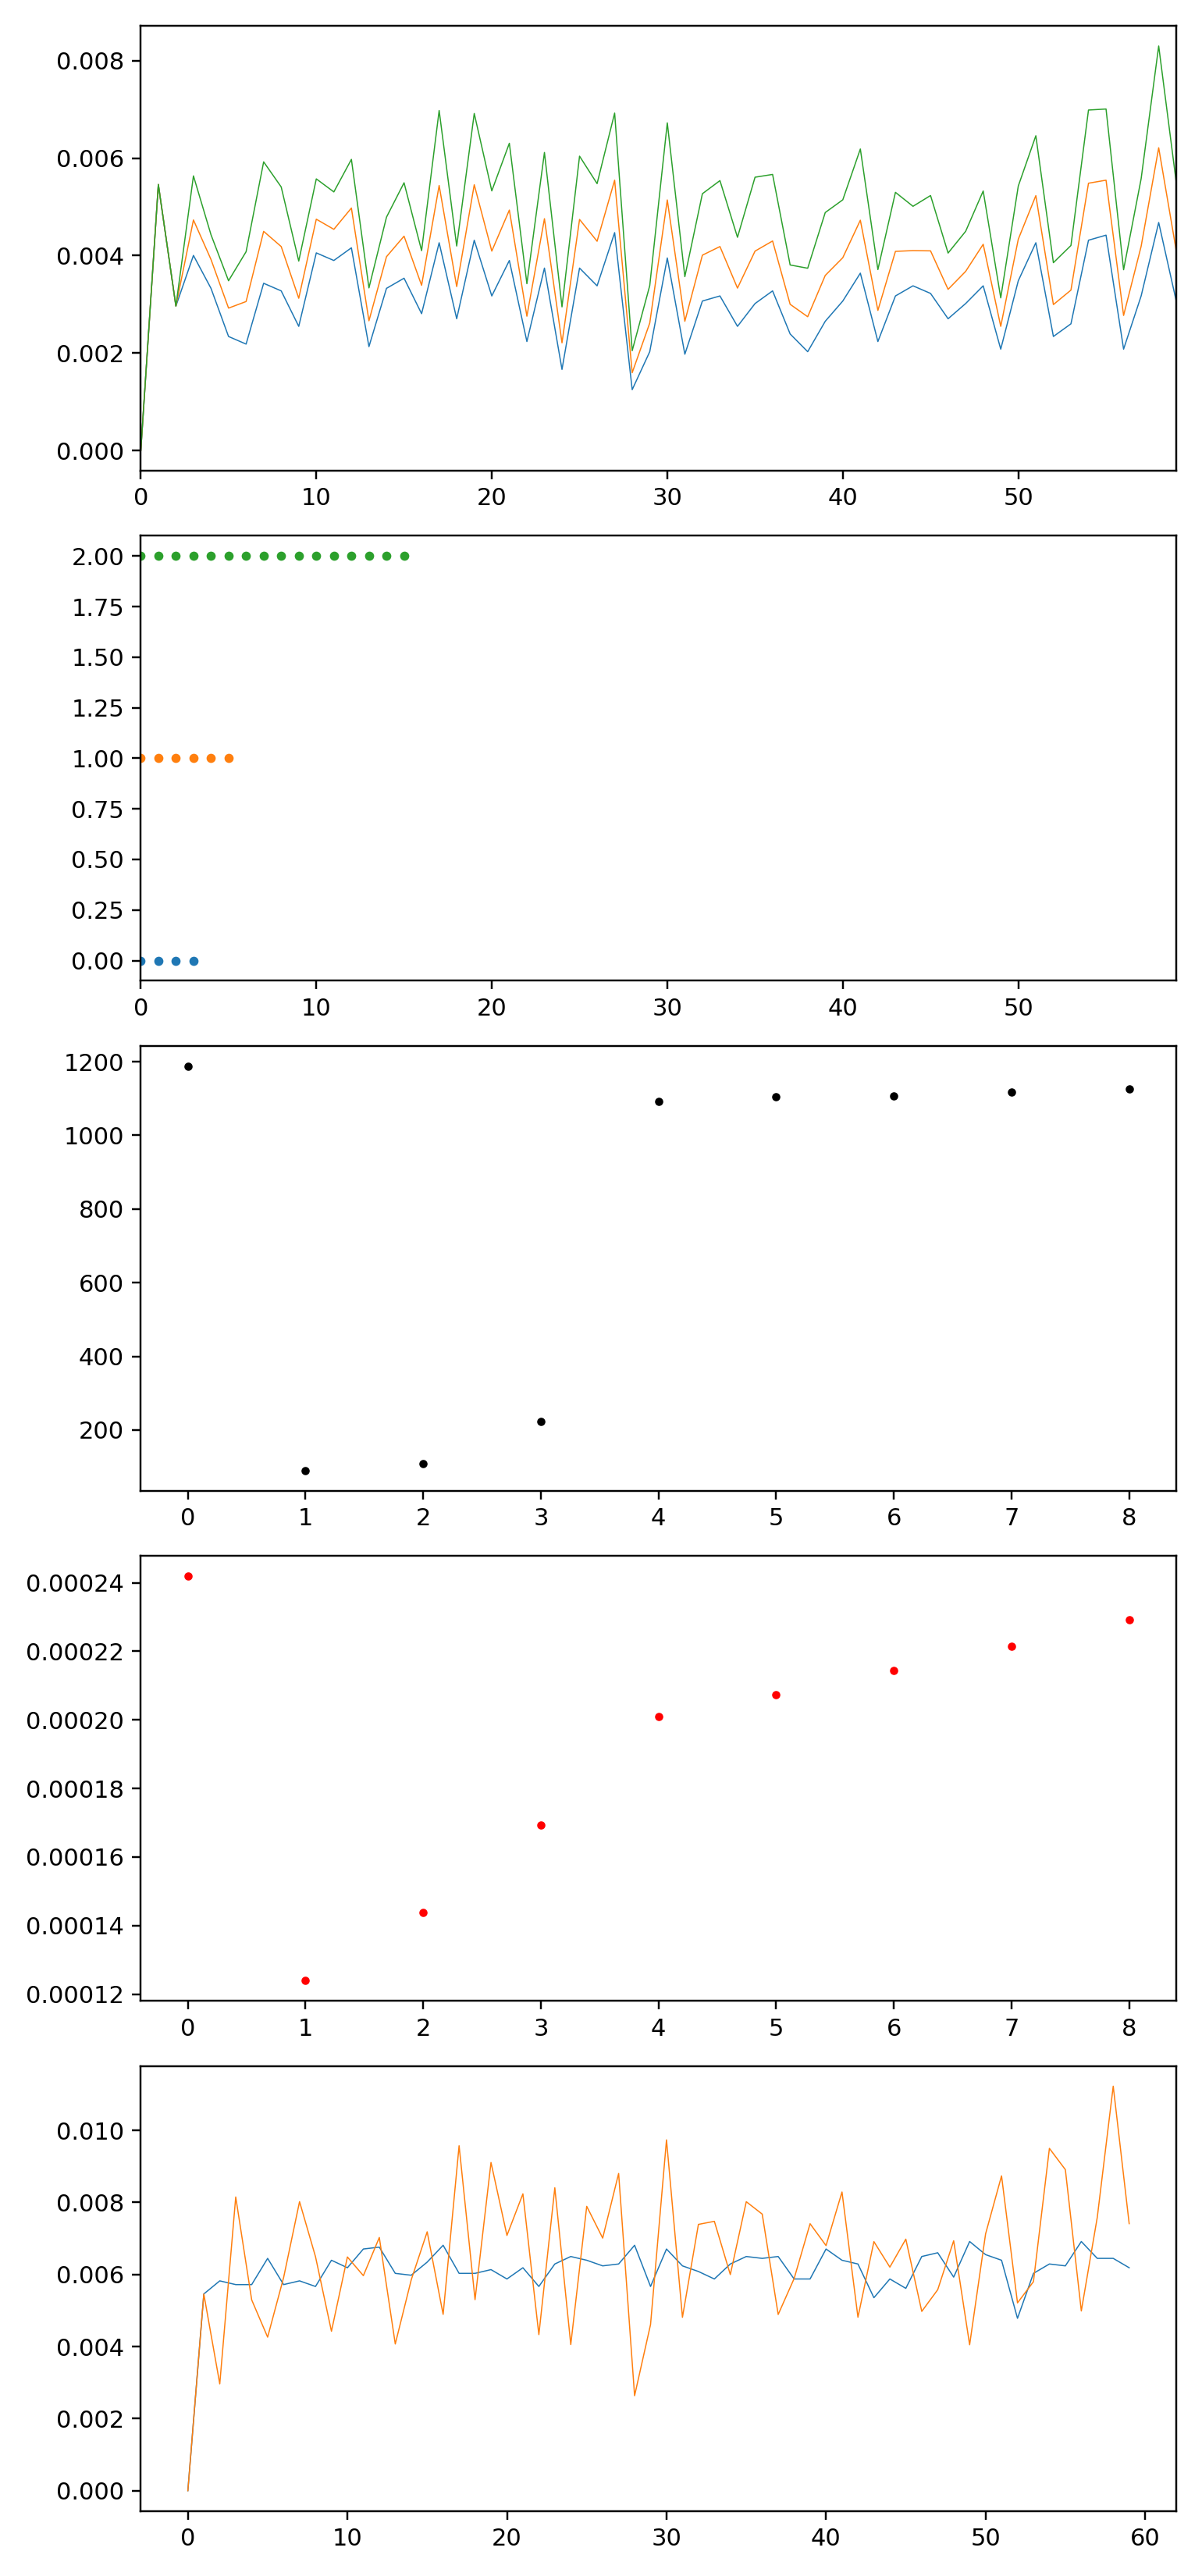

<IPython.core.display.Javascript object>


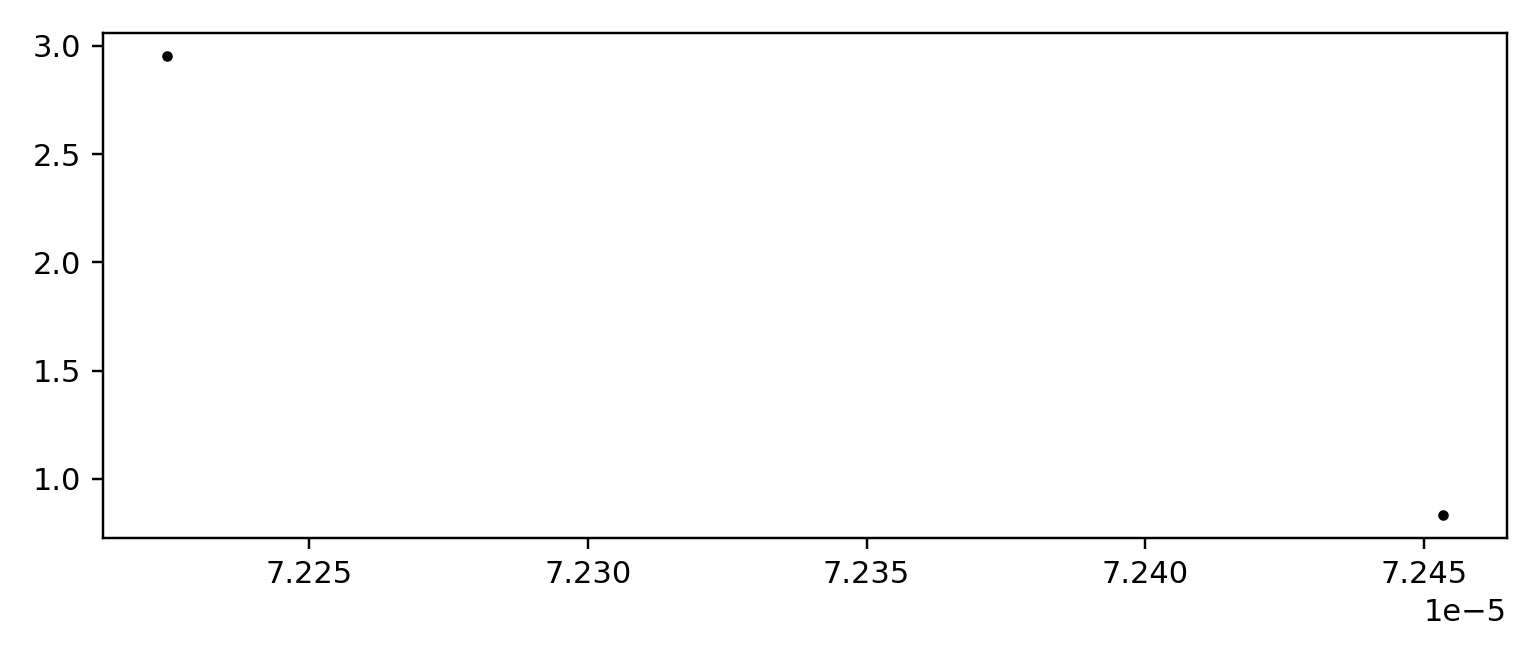

2


In [20]:
num_layers = 59
count = 0
all_std_incoming_summed_weights_perturbed = []
ratios_of_mean_incoming_summed_weights = []

for exp_dir_name in all_dirs:
    count += 1
    fig, ax = plt.subplots(5, 1, figsize=(7, 15), tight_layout=True)
    exp_data = load_exp_data(os.path.join('./robustness', exp_dir_name))
    
    std_incoming_summed_weights_perturbed = exp_data['std_incoming_summed_weights'].iloc[1]
    
    last_failed_trial = 0
    
    failing_trials = exp_data[exp_data['last_layer_active'] < num_layers]
    for i_trial in range(len(failing_trials)):
        layer_weights = failing_trials['layer_weights'].iloc[i_trial]
        ax[0].plot(np.arange(len(layer_weights)), layer_weights, lw=0.5)
        
        last_layer_active = failing_trials['last_layer_active'].iloc[i_trial]
        ax[1].scatter(np.arange(int(last_layer_active)), i_trial * np.ones(int(last_layer_active)), s=8)
        
        trial_index = failing_trials['index'].iloc[i_trial]
        if trial_index > last_failed_trial:
            last_failed_trial = int(trial_index)
    
    try:
        initial_mean_incoming_summed_weights = np.mean(exp_data['mean_incoming_summed_weights'].iloc[0])
        recovered_mean_incoming_summed_weights = np.mean(exp_data['mean_incoming_summed_weights'].iloc[last_failed_trial + 1])

        ratios_of_mean_incoming_summed_weights.append(recovered_mean_incoming_summed_weights / initial_mean_incoming_summed_weights)
        
        all_std_incoming_summed_weights_perturbed.append(std_incoming_summed_weights_perturbed)
    except IndexError as e:
        pass
    
    for i_trial in range(len(exp_data)):
        ax[2].scatter([i_trial], [np.sum(np.where(~np.isnan(exp_data['first_spk_times'].iloc[i_trial]), 1, 0))], c='black', s=6)
        ax[3].scatter([i_trial], [exp_data['mean_incoming_summed_weights'].iloc[i_trial]], c='red', s=6)
        
    for i_trial in range(0, len(exp_data), 5):
        layer_weights = exp_data['layer_weights'].iloc[i_trial]
        ax[4].plot(np.arange(len(layer_weights)), layer_weights, lw=0.5)
        
    for i in range(2):
        ax[i].set_xlim(0, num_layers)

fig, ax = plt.subplots(1, 1, figsize=(7, 3), tight_layout=True)
ax.scatter(all_std_incoming_summed_weights_perturbed, ratios_of_mean_incoming_summed_weights, s=6, c='black')
    
print(count)

<IPython.core.display.Javascript object>


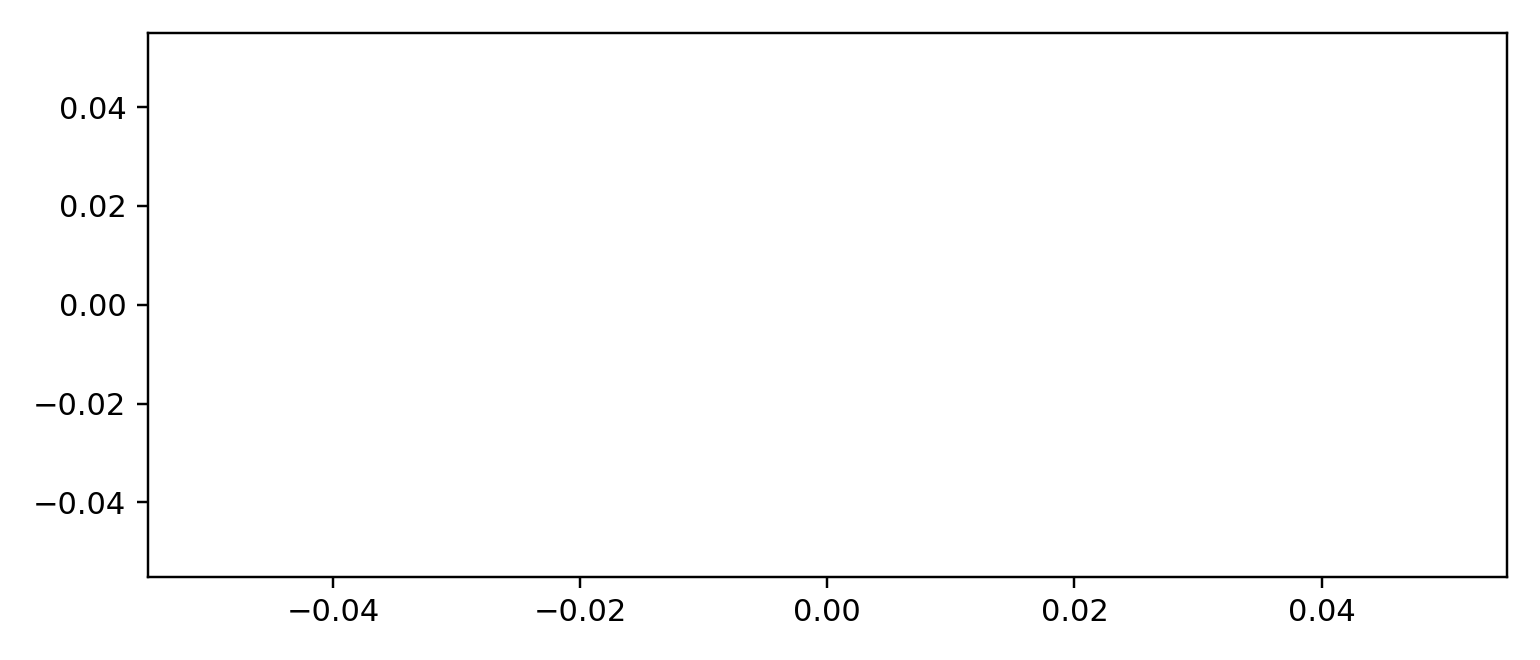

0


In [6]:
all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), ['noise_ff_0.8_pf_0.3_pr_0.0_eir_2.0_ier_0.3'])

num_layers = 59
count = 0
all_std_incoming_summed_weights_perturbed = []
ratios_of_mean_incoming_summed_weights = []

for exp_dir_name in all_dirs:
    count += 1
    fig, ax = plt.subplots(5, 1, figsize=(7, 15), tight_layout=True)
    exp_data = load_exp_data(os.path.join('./robustness', exp_dir_name), cut=30)
    
    std_incoming_summed_weights_perturbed = exp_data['std_incoming_summed_weights'].iloc[1]
    
    last_failed_trial = 0
    
    failing_trials = exp_data[exp_data['last_layer_active'] < num_layers]
    for i_trial in range(len(failing_trials)):
        layer_weights = failing_trials['layer_weights'].iloc[i_trial]
        ax[0].plot(np.arange(len(layer_weights)), layer_weights, lw=0.5)
        
        last_layer_active = failing_trials['last_layer_active'].iloc[i_trial]
        ax[1].scatter(np.arange(int(last_layer_active)), i_trial * np.ones(int(last_layer_active)), s=8)
        
        trial_index = failing_trials['index'].iloc[i_trial]
        if trial_index > last_failed_trial:
            last_failed_trial = trial_index
    
    try:
        initial_mean_incoming_summed_weights = np.mean(exp_data['mean_incoming_summed_weights'].iloc[0])
        recovered_mean_incoming_summed_weights = np.mean(exp_data['mean_incoming_summed_weights'].iloc[29])

        ratios_of_mean_incoming_summed_weights.append(recovered_mean_incoming_summed_weights / initial_mean_incoming_summed_weights)
        
        all_std_incoming_summed_weights_perturbed.append(std_incoming_summed_weights_perturbed)
    except IndexError as e:
        pass
    
    for i_trial in range(len(exp_data)):
        ax[2].scatter([i_trial], [np.sum(np.where(~np.isnan(exp_data['first_spk_times'].iloc[i_trial]), 1, 0))], c='black', s=6)
        ax[3].scatter([i_trial], [exp_data['mean_incoming_summed_weights'].iloc[i_trial]], c='red', s=6)
        
    for i_trial in range(0, len(exp_data), 5):
        layer_weights = exp_data['layer_weights'].iloc[i_trial]
        ax[4].plot(np.arange(len(layer_weights)), layer_weights, lw=0.5)
        
    for i in range(2):
        ax[i].set_xlim(0, num_layers)

fig, ax = plt.subplots(1, 1, figsize=(7, 3), tight_layout=True)
ax.scatter(all_std_incoming_summed_weights_perturbed, ratios_of_mean_incoming_summed_weights, s=6, c='black')
    
print(count)

In [107]:
def plot_w_r(w_r, row_min=0, row_max=None, col_min=0, col_max=None, layer_size=20):
    if row_max is None:
        row_max = w_r.shape[0]
    if col_max is None:
        col_max = w_r.shape[1]
    target_w_r = w_r[row_min:row_max, col_min:col_max]
    
    graph_weight_matrix(target_w_r, '', v_max=None, cmap='hot')
    
    incoming_weights = target_w_r.sum(axis=1)
    fig, ax = plt.subplots(4, 1, figsize=(7, 12), tight_layout=True)
    ax[0].scatter(np.arange(len(incoming_weights)), incoming_weights, s=3)
    ax[0].set_ylabel('Summed Incoming Synapse Strength')
    
    print(f'average summed incoming weight per cell: {np.mean(incoming_weights)} +/- {np.std(incoming_weights)}')

    thresh = 1e-7
    thresholded = np.where(target_w_r > thresh, 1, 0)
    thresholded_target_w_r = np.where(thresholded, target_w_r, np.nan)
    counts = np.count_nonzero(thresholded, axis=1)
    print(f'average incoming connections per cell: {np.mean(counts)} +/- {np.std(counts)}')

    ax[1].fill_between(x=np.arange(len(incoming_weights)),
                   y1=np.nanmean(thresholded_target_w_r, axis=1) - np.nanstd(thresholded_target_w_r, axis=1)/np.sqrt(counts),
                   y2=np.nanmean(thresholded_target_w_r, axis=1) + np.nanstd(thresholded_target_w_r, axis=1)/np.sqrt(counts),
                    color='red', alpha=0.2)

    ax[1].scatter(np.arange(len(incoming_weights)), np.nanmean(thresholded_target_w_r, axis=1), s=1, c='red')  
    
    ax[1].set_ylabel('Incoming Individual Synapse Strength')

    ax[2].scatter(np.arange(len(counts)), counts, c='red', s=3)
    ax[2].set_xlabel('Neuron Idx')
    ax[2].set_ylabel('Num Connections over Threshold')
    
    total_weight_per_layer = []
    for layer_start in range(0, target_w_r.shape[0], layer_size):
        layer_weight = np.sum(incoming_weights[layer_start:(layer_start + layer_size)])
        ax[3].scatter([layer_start/layer_size], [layer_weight], c='black', s=6)